# Finetune Embeddings

В этом блокноте мы показываем, как мы настраивали собственную модель для retriver.

Мы рассмотрим три основных раздела:
1. Генерация  данных
2. Настройка обучения модели
3. Оценка модели на основе проверочного корпуса знаний

## Necessary imports

In [ ]:
!pip install llama-index-llms-openai llama-index-finetuning llama-index-embeddings-openai datasets

In [ ]:
!pip install -U sentence-transformers rank_bm25 langchain langchain-openai openai transformers sentencepiece llama-index langchain-community chromadb umap-learn

  Using cached sentence_transformers-3.1.0-py3-none-any.whl.metadata (23 kB)
  Using cached rank_bm25-0.2.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached langchain-0.2.16-py3-none-any.whl.metadata (7.1 kB)
  Using cached langchain_openai-0.1.24-py3-none-any.whl.metadata (2.6 kB)
  Using cached sentencepiece-0.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.7 kB)
  Using cached llama_index-0.11.9-py3-none-any.whl.metadata (11 kB)
  Using cached langchain_community-0.2.16-py3-none-any.whl.metadata (2.7 kB)
  Using cached chromadb-0.5.5-py3-none-any.whl.metadata (6.8 kB)
  Using cached umap_learn-0.5.6-py3-none-any.whl.metadata (21 kB)
  Using cached langchain_core-0.2.39-py3-none-any.whl.metadata (6.2 kB)
  Using cached langchain_text_splitters-0.2.4-py3-none-any.whl.metadata (2.3 kB)
  Using cached langsmith-0.1.120-py3-none-any.whl.metadata (13 kB)
  Using cached llama_index_cli-0.3.1-py3-none-any.whl.metadata (1.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import nest_asyncio

nest_asyncio.apply()

import os
from getpass import getpass
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from tqdm.autonotebook import tqdm
import logging
from pydantic import BaseModel, Field
import json
import concurrent.futures
import aiohttp
import asyncio
from datasets import Dataset

from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.prompts import PromptTemplate
from langchain.docstore.document import Document
from langchain.chains import LLMChain
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langchain_community.document_transformers import (
    LongContextReorder
)
from langchain_community.document_loaders import TextLoader

from llama_index.finetuning import EmbeddingQAFinetuneDataset
from llama_index.finetuning import SentenceTransformersFinetuneEngine
from llama_index.core import SimpleDirectoryReader
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.schema import MetadataMode
from llama_index.finetuning import generate_qa_embedding_pairs
from llama_index.core.evaluation import EmbeddingQAFinetuneDataset
from llama_index.core.evaluation import RetrieverEvaluator
from llama_index.core.evaluation import generate_question_context_pairs
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, ServiceContext
from llama_index.core.node_parser import SimpleNodeParser
from llama_index.llms.openai import OpenAI

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from sentence_transformers import SentenceTransformer, CrossEncoder, util, losses

from rank_bm25 import BM25Okapi
from sklearn.feature_extraction import _stop_words
import string

<ipython-input-3-5e39a2730022>:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device - {device}')

Device - cpu


In [ ]:
%cd /content/drive/MyDrive/COurses_WOrk/AI_Hack
!ls

/content/drive/MyDrive/COurses_WOrk/AI_Hack
 answers.csv			 production_rag_example.ipynb
 answers.gsheet			 production_rag_validation.ipynb
 checkpoints			 rag-eval.ipynb
 docs_from_path			 results
 fine_tune_big_dataset		 results_Self_Validation_Pipeline.csv
 fine-tuned-model		 results-v2
 fine-tuned-model-v2		 testRag.ipynb
'finetune_embedding.ipynb"'	 total_rag
 finetune_embedding_v2.ipynb	 v2_fine_tune
 fine_tune_train_data		 v2_ragas_npa_dataset_firstPart.xlsx
 hmao_npa_cleaned_v1.txt	'Копия блокнота "finetune_embedding.ipynb"'
'notebookccf68588d3 (1).ipynb'


## Split data for generation

In [ ]:
file_path = os.path.dirname("hmao_npa_cleaned_v2.txt")

In [ ]:
reader = SimpleDirectoryReader(input_dir='docs_from_path')
docs_from_dir = reader.load_data()

In [ ]:
parser = SentenceSplitter(
    chunk_size=512,    # Максимальный размер куска текста в токенах
    chunk_overlap=20,  # Перекрытие между соседними частями текста
    separator=".",     # Разделитель предложений, можно настроить под другие языки или символы
)
nodes = parser.get_nodes_from_documents(docs_from_dir, show_progress=True)

Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
len(nodes)

27058

## Generate synthetic queries



*  Теперь мы используем LLM (gpt-4-о-mini) для генерации вопросов, используя каждый фрагмент текста в корпусе в качестве контекста.
*  Каждая пара (сгенерированный вопрос, фрагмент текста, используемый в качестве контекста) становится точкой данных в наборе данных тонкой настройки (для обучения и оценки).






In [ ]:
os.environ['OPENAI_API_KEY'] = getpass(prompt='Введите ваш OpenAI API ключ')

Введите ваш OpenAI API ключ··········


In [ ]:
train_nodes = nodes[:25000]
val_nodes = nodes[25000:]
len(val_nodes)

2058

**Custom prompt for qa generation**

Для правильной генерации на русском языке используем собственный промпт

In [ ]:
llm = OpenAI(model="gpt-4o-mini")

DEFAULT_QA_GENERATE_PROMPT_TMPL = """
Контекстная информация приведена ниже.

---------------------
{context_str}
---------------------

Учитывая контекстную информацию, а не предыдущие знания.

создайте только вопросы на основе приведенного ниже запроса.
Отвечайте на том языке, на котором получаете контекст.

Вы преподаватель/профессор. Ваша задача — настроить \
{num_questions_per_chunk} вопросов для предстоящего \
теста/экзамена. Вопросы должны быть разнообразными по своей природе \
по всему документу. Ограничьте вопросы \
предоставленной контекстной информацией.
"""


In [ ]:
train_dataset = generate_qa_embedding_pairs(
    llm=llm,
    nodes=nodes,
    qa_generate_prompt_tmpl=DEFAULT_QA_GENERATE_PROMPT_TMPL,
    num_questions_per_chunk = 2
)
train_dataset.save_json("ru_night_train_dataset_v2.json")

  4%|▍         | 1000/26558 [09:09<8:14:12,  1.16s/it]

Saved progress at 1000 entries.


  6%|▌         | 1500/26558 [19:14<9:17:10,  1.33s/it]

Saved progress at 1500 entries.


  8%|▊         | 2000/26558 [29:24<10:20:05,  1.52s/it]

Saved progress at 2000 entries.


  9%|▉         | 2500/26558 [39:40<9:18:39,  1.39s/it]

Saved progress at 2500 entries.


 11%|█▏        | 3000/26558 [49:14<7:39:48,  1.17s/it]

Saved progress at 3000 entries.


 13%|█▎        | 3500/26558 [59:50<13:33:45,  2.12s/it]

Saved progress at 3500 entries.


 15%|█▌        | 4000/26558 [1:09:14<6:35:11,  1.05s/it]

Saved progress at 4000 entries.


 17%|█▋        | 4500/26558 [1:19:04<8:02:41,  1.31s/it]

Saved progress at 4500 entries.


 19%|█▉        | 5000/26558 [1:28:22<10:59:13,  1.83s/it]

Saved progress at 5000 entries.


 21%|██        | 5500/26558 [1:37:55<7:27:07,  1.27s/it]

Saved progress at 5500 entries.


 23%|██▎       | 6000/26558 [1:47:33<7:09:02,  1.25s/it]

Saved progress at 6000 entries.


 24%|██▍       | 6500/26558 [1:57:11<6:00:51,  1.08s/it]

Saved progress at 6500 entries.


 26%|██▋       | 7000/26558 [2:05:59<6:06:46,  1.13s/it]

Saved progress at 7000 entries.


 28%|██▊       | 7500/26558 [2:15:59<10:54:29,  2.06s/it]

Saved progress at 7500 entries.


 30%|███       | 8000/26558 [2:24:57<7:17:19,  1.41s/it]

Saved progress at 8000 entries.


 32%|███▏      | 8500/26558 [2:34:00<5:49:01,  1.16s/it]

Saved progress at 8500 entries.


 34%|███▍      | 9000/26558 [2:43:09<5:51:36,  1.20s/it]

Saved progress at 9000 entries.


 36%|███▌      | 9500/26558 [2:52:30<6:19:18,  1.33s/it]

Saved progress at 9500 entries.


 38%|███▊      | 10000/26558 [3:01:24<7:02:11,  1.53s/it]

Saved progress at 10000 entries.


 40%|███▉      | 10500/26558 [3:10:45<7:54:48,  1.77s/it]

Saved progress at 10500 entries.


 41%|████▏     | 11000/26558 [3:20:06<5:48:54,  1.35s/it]

Saved progress at 11000 entries.


 43%|████▎     | 11500/26558 [3:30:16<5:04:47,  1.21s/it]

Saved progress at 11500 entries.


 45%|████▌     | 12000/26558 [4:34:59<30:26:36,  7.53s/it]

Saved progress at 12000 entries.


 47%|████▋     | 12500/26558 [5:47:04<38:12:21,  9.78s/it]

Saved progress at 12500 entries.


 49%|████▉     | 13000/26558 [6:59:01<35:11:57,  9.35s/it]

Saved progress at 13000 entries.


 51%|█████     | 13500/26558 [8:11:03<35:05:25,  9.67s/it]

Saved progress at 13500 entries.


 53%|█████▎    | 14000/26558 [9:23:05<34:52:00, 10.00s/it]

Saved progress at 14000 entries.


 55%|█████▍    | 14500/26558 [10:35:04<32:51:22,  9.81s/it]

Saved progress at 14500 entries.


 56%|█████▋    | 15000/26558 [11:47:01<28:48:25,  8.97s/it]

Saved progress at 15000 entries.


 56%|█████▋    | 15002/26558 [11:47:26<9:23:43,  2.93s/it] 


KeyboardInterrupt: 

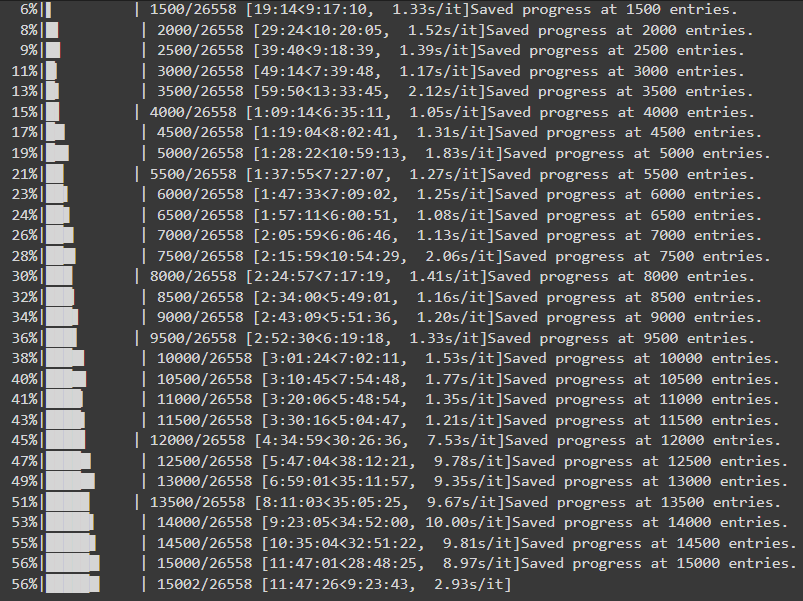

In [ ]:
train_dataset = generate_qa_embedding_pairs(
    llm=llm,
    nodes=nodes,
    qa_generate_prompt_tmpl=DEFAULT_QA_GENERATE_PROMPT_TMPL,
    num_questions_per_chunk = 2
)
train_dataset.save_json("ru_night_train_dataset_v2.json")

15500it [1:11:44,  8.78s/it]

Saved progress at 15500 entries.


16000it [2:23:46, 10.01s/it]

Saved progress at 16000 entries.


16500it [3:35:41,  8.33s/it]

Saved progress at 16500 entries.


17000it [4:47:43,  8.69s/it]

Saved progress at 17000 entries.


17113it [5:03:56,  8.63s/it]


KeyboardInterrupt: 

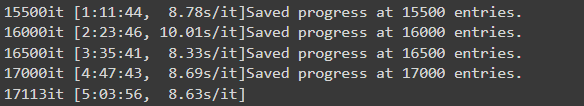

В итоге были сгенерированы два датасета:

* dataset_v1 - 8 часов, 40к вопросов на 14к чанков ( 1200 токенов )

* dataset_v2 - 17 часов, 34к вопросов на 27к чанков ( 512 токенов )

За базовую модель в ретривере мы берем

> multilingual-e5-large

Ее контекстное окно 512 токенов.

  У вас мог возникнуть логичный вопрос - почему же вы тогда нарезали текст на чанки в 1200 токенов в первом датасете?

Мы примерно посчитали длительность генерации вычислений + дообучение модели с 600 миллионами параметров и решили, что для начала надо попробовать за меньший промежуток времени получить хотя бы какой-то прирост (хоть и не так эффективно).


In [ ]:
val_dataset = generate_qa_embedding_pairs(
    llm=llm,
    nodes=val_nodes,
    qa_generate_prompt_tmpl=DEFAULT_QA_GENERATE_PROMPT_TMPL,
    num_questions_per_chunk = 1
)
val_dataset.save_json("ru_night_val_dataset_v2.json")

 64%|██████▍   | 1000/1558 [1:03:22<1:26:03,  9.25s/it]

Saved progress at 1000 entries.


 65%|██████▍   | 1007/1558 [1:04:22<1:09:57,  7.62s/it]


KeyboardInterrupt: 

In [ ]:
train_dataset.keys()

dict_keys(['queries', 'corpus', 'relevant_docs', 'mode'])

## Run Embedding Finetuning

In [ ]:
train_data_path = 'v2_fine_tune/qa_finetune_dataset_train_512_v2.json'
val_data_path = 'v2_fine_tune/qa_finetune_dataset_val_512_v2.json'

In [ ]:
train_dataset_class = EmbeddingQAFinetuneDataset.from_json(train_data_path)
val_dataset_class = EmbeddingQAFinetuneDataset.from_json(val_data_path)

In [ ]:
#model = SentenceTransformer('intfloat/multilingual-e5-large')
#loss = losses.MultipleNegativesRankingLoss(model) - это базовый лосс

finetune_engine = SentenceTransformersFinetuneEngine(
    dataset = train_dataset_class,
    model_id="intfloat/multilingual-e5-large",
    model_output_path="./fine-tuned-model-v2",
    batch_size=16,
    device=device,
    val_dataset=val_dataset_class,

)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/160k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

In [ ]:
torch.cuda.empty_cache()

In [ ]:
finetune_engine.finetune()

Step,Training Loss,Validation Loss,Cosine Accuracy@1,Cosine Accuracy@3,Cosine Accuracy@5,Cosine Accuracy@10,Cosine Precision@1,Cosine Precision@3,Cosine Precision@5,Cosine Precision@10,Cosine Recall@1,Cosine Recall@3,Cosine Recall@5,Cosine Recall@10,Cosine Ndcg@10,Cosine Mrr@10,Cosine Map@100,Dot Accuracy@1,Dot Accuracy@3,Dot Accuracy@5,Dot Accuracy@10,Dot Precision@1,Dot Precision@3,Dot Precision@5,Dot Precision@10,Dot Recall@1,Dot Recall@3,Dot Recall@5,Dot Recall@10,Dot Ndcg@10,Dot Mrr@10,Dot Map@100
50,No log,No log,0.674000,0.841000,0.889000,0.934000,0.674000,0.280333,0.177800,0.093400,0.674000,0.841000,0.889000,0.934000,0.807312,0.766319,0.768903,0.674000,0.841000,0.889000,0.934000,0.674000,0.280333,0.177800,0.093400,0.674000,0.841000,0.889000,0.934000,0.807312,0.766319,0.768903
100,No log,No log,0.634000,0.814000,0.866000,0.921000,0.634000,0.271333,0.173200,0.092100,0.634000,0.814000,0.866000,0.921000,0.778453,0.732468,0.735975,0.634000,0.814000,0.866000,0.921000,0.634000,0.271333,0.173200,0.092100,0.634000,0.814000,0.866000,0.921000,0.778453,0.732468,0.735975
150,No log,No log,0.667000,0.843000,0.888000,0.938000,0.667000,0.281000,0.177600,0.093800,0.667000,0.843000,0.888000,0.938000,0.805638,0.762864,0.766200,0.667000,0.843000,0.888000,0.938000,0.667000,0.281000,0.177600,0.093800,0.667000,0.843000,0.888000,0.938000,0.805638,0.762864,0.766200
200,No log,No log,0.644000,0.842000,0.895000,0.939000,0.644000,0.280667,0.179000,0.093900,0.644000,0.842000,0.895000,0.939000,0.797658,0.751598,0.754735,0.644000,0.842000,0.895000,0.939000,0.644000,0.280667,0.179000,0.093900,0.644000,0.842000,0.895000,0.939000,0.797658,0.751598,0.754735
250,No log,No log,0.650000,0.852000,0.914000,0.949000,0.650000,0.284000,0.182800,0.094900,0.650000,0.852000,0.914000,0.949000,0.806014,0.759254,0.761733,0.650000,0.852000,0.914000,0.949000,0.650000,0.284000,0.182800,0.094900,0.650000,0.852000,0.914000,0.949000,0.806014,0.759254,0.761733
300,No log,No log,0.674000,0.856000,0.909000,0.954000,0.674000,0.285333,0.181800,0.095400,0.674000,0.856000,0.909000,0.954000,0.819026,0.775108,0.777505,0.674000,0.856000,0.909000,0.954000,0.674000,0.285333,0.181800,0.095400,0.674000,0.856000,0.909000,0.954000,0.819026,0.775108,0.777505
350,No log,No log,0.677000,0.851000,0.912000,0.948000,0.677000,0.283667,0.182400,0.094800,0.677000,0.851000,0.912000,0.948000,0.816780,0.774051,0.776725,0.677000,0.851000,0.912000,0.948000,0.677000,0.283667,0.182400,0.094800,0.677000,0.851000,0.912000,0.948000,0.816780,0.774051,0.776725
400,No log,No log,0.649000,0.855000,0.908000,0.959000,0.649000,0.285000,0.181600,0.095900,0.649000,0.855000,0.908000,0.959000,0.809060,0.760348,0.762536,0.649000,0.855000,0.908000,0.959000,0.649000,0.285000,0.181600,0.095900,0.649000,0.855000,0.908000,0.959000,0.809060,0.760348,0.762536
450,No log,No log,0.665000,0.849000,0.902000,0.953000,0.665000,0.283000,0.180400,0.095300,0.665000,0.849000,0.902000,0.953000,0.811086,0.765278,0.767746,0.665000,0.849000,0.902000,0.953000,0.665000,0.283000,0.180400,0.095300,0.665000,0.849000,0.902000,0.953000,0.811086,0.765278,0.767746
500,0.194500,No log,0.676000,0.852000,0.907000,0.959000,0.676000,0.284000,0.181400,0.095900,0.676000,0.852000,0.907000,0.959000,0.819316,0.774323,0.776475,0.676000,0.852000,0.907000,0.959000,0.676000,0.284000,0.181400,0.095900,0.676000,0.852000,0.907000,0.959000,0.819316,0.774323,0.776475


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Cosine Accuracy@1,Cosine Accuracy@3,Cosine Accuracy@5,Cosine Accuracy@10,Cosine Precision@1,Cosine Precision@3,Cosine Precision@5,Cosine Precision@10,Cosine Recall@1,Cosine Recall@3,Cosine Recall@5,Cosine Recall@10,Cosine Ndcg@10,Cosine Mrr@10,Cosine Map@100,Dot Accuracy@1,Dot Accuracy@3,Dot Accuracy@5,Dot Accuracy@10,Dot Precision@1,Dot Precision@3,Dot Precision@5,Dot Precision@10,Dot Recall@1,Dot Recall@3,Dot Recall@5,Dot Recall@10,Dot Ndcg@10,Dot Mrr@10,Dot Map@100
50,No log,No log,0.674000,0.841000,0.889000,0.934000,0.674000,0.280333,0.177800,0.093400,0.674000,0.841000,0.889000,0.934000,0.807312,0.766319,0.768903,0.674000,0.841000,0.889000,0.934000,0.674000,0.280333,0.177800,0.093400,0.674000,0.841000,0.889000,0.934000,0.807312,0.766319,0.768903
100,No log,No log,0.634000,0.814000,0.866000,0.921000,0.634000,0.271333,0.173200,0.092100,0.634000,0.814000,0.866000,0.921000,0.778453,0.732468,0.735975,0.634000,0.814000,0.866000,0.921000,0.634000,0.271333,0.173200,0.092100,0.634000,0.814000,0.866000,0.921000,0.778453,0.732468,0.735975
150,No log,No log,0.667000,0.843000,0.888000,0.938000,0.667000,0.281000,0.177600,0.093800,0.667000,0.843000,0.888000,0.938000,0.805638,0.762864,0.766200,0.667000,0.843000,0.888000,0.938000,0.667000,0.281000,0.177600,0.093800,0.667000,0.843000,0.888000,0.938000,0.805638,0.762864,0.766200
200,No log,No log,0.644000,0.842000,0.895000,0.939000,0.644000,0.280667,0.179000,0.093900,0.644000,0.842000,0.895000,0.939000,0.797658,0.751598,0.754735,0.644000,0.842000,0.895000,0.939000,0.644000,0.280667,0.179000,0.093900,0.644000,0.842000,0.895000,0.939000,0.797658,0.751598,0.754735
250,No log,No log,0.650000,0.852000,0.914000,0.949000,0.650000,0.284000,0.182800,0.094900,0.650000,0.852000,0.914000,0.949000,0.806014,0.759254,0.761733,0.650000,0.852000,0.914000,0.949000,0.650000,0.284000,0.182800,0.094900,0.650000,0.852000,0.914000,0.949000,0.806014,0.759254,0.761733
300,No log,No log,0.674000,0.856000,0.909000,0.954000,0.674000,0.285333,0.181800,0.095400,0.674000,0.856000,0.909000,0.954000,0.819026,0.775108,0.777505,0.674000,0.856000,0.909000,0.954000,0.674000,0.285333,0.181800,0.095400,0.674000,0.856000,0.909000,0.954000,0.819026,0.775108,0.777505
350,No log,No log,0.677000,0.851000,0.912000,0.948000,0.677000,0.283667,0.182400,0.094800,0.677000,0.851000,0.912000,0.948000,0.816780,0.774051,0.776725,0.677000,0.851000,0.912000,0.948000,0.677000,0.283667,0.182400,0.094800,0.677000,0.851000,0.912000,0.948000,0.816780,0.774051,0.776725
400,No log,No log,0.649000,0.855000,0.908000,0.959000,0.649000,0.285000,0.181600,0.095900,0.649000,0.855000,0.908000,0.959000,0.809060,0.760348,0.762536,0.649000,0.855000,0.908000,0.959000,0.649000,0.285000,0.181600,0.095900,0.649000,0.855000,0.908000,0.959000,0.809060,0.760348,0.762536
450,No log,No log,0.665000,0.849000,0.902000,0.953000,0.665000,0.283000,0.180400,0.095300,0.665000,0.849000,0.902000,0.953000,0.811086,0.765278,0.767746,0.665000,0.849000,0.902000,0.953000,0.665000,0.283000,0.180400,0.095300,0.665000,0.849000,0.902000,0.953000,0.811086,0.765278,0.767746
500,0.194500,No log,0.676000,0.852000,0.907000,0.959000,0.676000,0.284000,0.181400,0.095900,0.676000,0.852000,0.907000,0.959000,0.819316,0.774323,0.776475,0.676000,0.852000,0.907000,0.959000,0.676000,0.284000,0.181400,0.095900,0.676000,0.852000,0.907000,0.959000,0.819316,0.774323,0.776475


In [ ]:
embed_model = finetune_engine.get_finetuned_model()

In [ ]:
embed_model

HuggingFaceEmbedding(model_name='./fine-tuned-model', embed_batch_size=10, callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x785c112b1e10>, num_workers=None, max_length=512, normalize=True, query_instruction=None, text_instruction=None, cache_folder=None)

## Download to HF

Запушим нашу модель на сервер Hugging Face, для упрощения обращения к ней.

In [ ]:
!pip install llama-index-embeddings-huggingface transformers huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 861.9/861.9 kB 11.9 MB/s eta 0:00:00


In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
from transformers import AutoModel, AutoTokenizer

model_path = "./fine-tuned-model-v2"

transformer_model = AutoModel.from_pretrained(model_path)
transformer_tokenizer = AutoTokenizer.from_pretrained(model_path)


In [ ]:
from huggingface_hub import create_repo

# Загрузка в Hugging Face Hub
transformer_model.push_to_hub("ianssens/e5-rag-v2.2")
transformer_tokenizer.push_to_hub("ianssens/e5-rag-v2.2")

README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ianssens/e5-rag-v2.2/commit/912fcb8491dd66d708d0d9c12f37fac635ad6238', commit_message='Upload tokenizer', commit_description='', oid='912fcb8491dd66d708d0d9c12f37fac635ad6238', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
from datasets import Dataset
from huggingface_hub import create_repo, HfApi


# Загрузка датасета из JSON
dataset = Dataset.from_json('path_to_your_dataset.json')

# Загрузка датасета в созданный репозиторий
dataset.push_to_hub("my-username/my-json-dataset")


## Evaluate Finetuned Model

В этом разделе мы оцениваем 3 различные модели:
1. Исходную `e5-large`,
2. Дообученную на первом датасете `e5-large-v1`
3. И итоговую дообученную `e5-large-v2`

Мы рассматриваем такой подход к оценке:
* использование `InformationRetrievalEvaluator` из sentence_transformers

Мы показываем, что finetune на синтетическом (сгенерированном LLM) наборе данных значительно улучшает эмбеддер с открытым исходным кодом.

In [ ]:
from sentence_transformers.evaluation import InformationRetrievalEvaluator
from pathlib import Path
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core import VectorStoreIndex
from llama_index.core.schema import TextNode
from tqdm.notebook import tqdm
import pandas as pd

def evaluate_st(
    dataset,
    model_id,
    name,
):
    corpus = dataset.corpus
    queries = dataset.queries
    relevant_docs = dataset.relevant_docs

    evaluator = InformationRetrievalEvaluator(
        queries, corpus, relevant_docs, name=name
    )
    model = SentenceTransformer(model_id)
    output_path = "results-v2/"
    Path(output_path).mkdir(exist_ok=True, parents=True)
    return evaluator(model, output_path=output_path)


In [ ]:
model_path_v1 = "./fine-tuned-model"
model_path_v2 = "./fine-tuned-model-v2"

In [ ]:
e5_val_results = evaluate_st(val_dataset_class, 'intfloat/multilingual-e5-large', 'e5_val')

In [ ]:
e5_Fine_Tuning_val_results_v1 = evaluate_st(val_dataset_class, model_path_v1, 'e5_FineTune_val_v1')

In [ ]:
e5_Fine_Tuning_val_results_v2 = evaluate_st(val_dataset_class, model_path_v2, 'e5_FineTune_val_v2')

## Results

In [ ]:
df_e5 = pd.read_csv(
    "results-v2/Information-Retrieval_evaluation_e5_val_results.csv"
)
df_e5_finetuned_v1 = pd.read_csv(
    "results-v2/Information-Retrieval_evaluation_e5_FineTune_val_v1_results.csv"
)
df_e5_finetuned_v2 = pd.read_csv(
    "results-v2/Information-Retrieval_evaluation_e5_FineTune_val_v2_results.csv"
)

df_e5["model"] = "e5"
df_e5_finetuned_v1["model"] = "e5_v1"
df_e5_finetuned_v2["model"] = "e5_v2"
df_st_all = pd.concat([df_e5, df_e5_finetuned_v1, df_e5_finetuned_v2])
df_st_all = df_st_all.set_index("model")
df_st_all

,epoch,steps,cosine-Accuracy@1,cosine-Accuracy@3,cosine-Accuracy@5,cosine-Accuracy@10,cosine-Precision@1,cosine-Recall@1,cosine-Precision@3,cosine-Recall@3,...,dot-Recall@1,dot-Precision@3,dot-Recall@3,dot-Precision@5,dot-Recall@5,dot-Precision@10,dot-Recall@10,dot-MRR@10,dot-NDCG@10,dot-MAP@100
model,,,,,,,,,,,,,,,,,,,,,
e5,-1,-1,0.652,0.839,0.879,0.927,0.652,0.652,0.279667,0.839,...,0.652,0.279667,0.839,0.1758,0.879,0.0927,0.927,0.751872,0.794800,0.754762
e5_v1,-1,-1,0.715,0.907,0.940,0.977,0.715,0.715,0.302333,0.907,...,0.715,0.302333,0.907,0.1880,0.940,0.0977,0.977,0.816306,0.856144,0.817592
e5_v2,-1,-1,0.738,0.909,0.946,0.979,0.738,0.738,0.303000,0.909,...,0.738,0.303000,0.909,0.1892,0.946,0.0979,0.979,0.829436,0.866392,0.830739
